In [1]:
!echo "Last updated: `date`"

Last updated: Sat Aug 22 12:40:57 PDT 2020


In [73]:
# Libraries
import json
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS, HMC
import torch
import torch.distributions.constraints as constraints
from torch.nn.functional import pad
from tqdm import trange

# For ADVI
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, JitTrace_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.optim import Adam

# For GP
import pyro.contrib.gp as gp

import sys
sys.path.append('../util')
import gp_plot_util

# Default to double precision for torch objects.
torch.set_default_dtype(torch.float64)

# See also:
# http://docs.pyro.ai/en/stable/contrib.gp.html
# https://pyro.ai/examples/gp.html

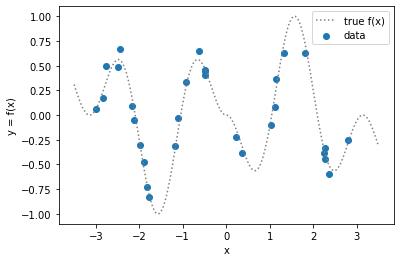

In [3]:
# Read data.
path_to_data = '../data/gp-data-N30.json'
simdata = json.load(open(path_to_data))

# Store data as torch.tensors.
X = torch.tensor(simdata['x']).reshape(-1, 1)
y = torch.tensor(simdata['y'])
x_grid = torch.tensor(simdata['x_grid'])
f = torch.tensor(simdata['f'])

# Plot data and true function.
plt.scatter(X, y, label='data')
plt.plot(x_grid, f, ls=':', c='grey', label='true f(x)')
plt.xlabel('x')
plt.ylabel('y = f(x)')
plt.legend();

In [70]:
# Model definition.
def sq_exp_kernel(d, alpha, rho):
    return alpha * alpha * torch.exp(-0.5 * torch.pow(d / rho, 2))

def sq_exp_kernel_matrix(X, alpha, rho):
    D = torch.cdist(X, X)
    return sq_exp_kernel(D, alpha, rho)

def gp_model(X, y):
    N = X.shape[0]
    
    # Priors for kernel parameters.
    alpha = pyro.sample("alpha", dist.LogNormal(0., 0.1))
    rho = pyro.sample("rho", dist.LogNormal(0., 1.))
    sigma = pyro.sample("sigma", dist.LogNormal(0., 1.))
    
    # Covariance matrix. 
    K = sq_exp_kernel_matrix(X, alpha, rho) + torch.eye(N) * sigma * sigma
    L = torch.cholesky(K)
    
    # Marginal likelihood.
    pyro.sample('obs',
                dist.MultivariateNormal(torch.zeros(N), scale_tril=L),
                obs=y)

In [64]:
%%time

### HMC ###
pyro.clear_param_store()

# Set random seed for reproducibility.
pyro.set_rng_seed(1)

# Set up HMC sampler.
hmc = MCMC(HMC(gp_model, step_size=0.01, trajectory_length=1,
               adapt_step_size=False, adapt_mass_matrix=False,
               jit_compile=True),
           num_samples=1000, warmup_steps=1000)
hmc.run(X, y)

# Get posterior samples
hmc_posterior_samples = hmc.get_samples()
hmc_posterior_samples = {k: hmc_posterior_samples[k].numpy()
                         for k in hmc_posterior_samples}

Sample: 100%|██████████| 2000/2000 [05:10,  6.45it/s, step size=1.00e-02, acc. prob=0.999]

CPU times: user 15min 27s, sys: 5.76 s, total: 15min 32s
Wall time: 5min 10s


In [65]:
%%time

### NUTS ###
pyro.clear_param_store()

# Set random seed for reproducibility.
pyro.set_rng_seed(1)

# Set up NUTS sampler.
nuts = MCMC(NUTS(gp_model, target_accept_prob=0.8, jit_compile=True),
            num_samples=1000, warmup_steps=1000)
%time nuts.run(X, y)

# Get posterior samples
nuts_posterior_samples = nuts.get_samples()
nuts_posterior_samples = {k: nuts_posterior_samples[k].numpy()
                          for k in nuts_posterior_samples}

Sample: 100%|██████████| 2000/2000 [00:20, 99.63it/s, step size=6.01e-01, acc. prob=0.936] 

CPU times: user 60 s, sys: 435 ms, total: 1min
Wall time: 20.1 s
CPU times: user 60 s, sys: 435 ms, total: 1min
Wall time: 20.1 s


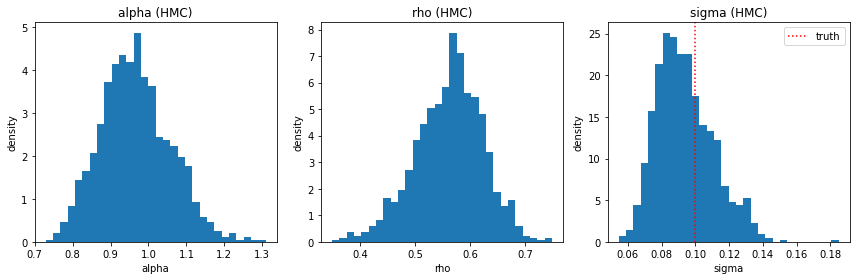

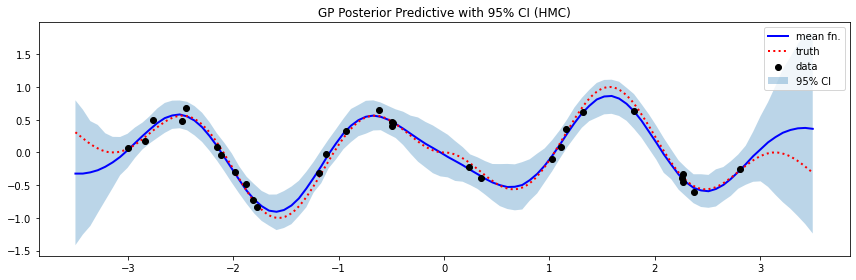

In [66]:
# Plot posterior for HMC
gp_plot_util.make_plots(hmc_posterior_samples, suffix="HMC",
                        x=X.flatten(), y=y, x_grid=x_grid, f=f, sigma_true=simdata['sigma'])

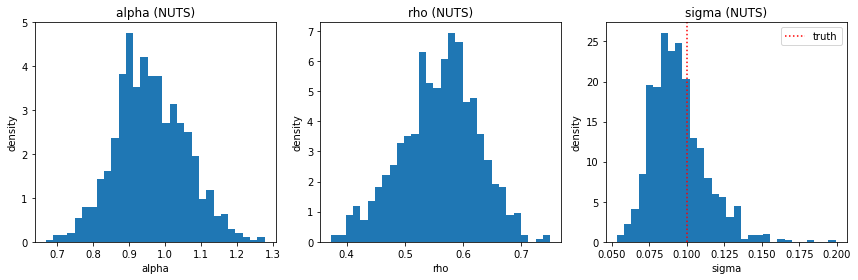

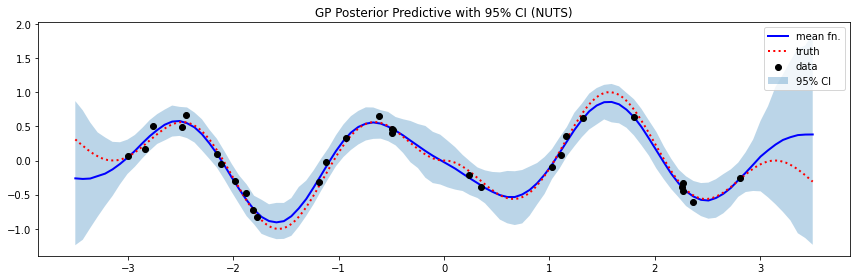

In [67]:
# Plot posterior for NUTS
gp_plot_util.make_plots(nuts_posterior_samples, suffix="NUTS",
                        x=X.flatten(), y=y, x_grid=x_grid, f=f, sigma_true=simdata['sigma'])

In [91]:
%%time 
# ADVI
pyro.clear_param_store()  # clear global parameter cache
pyro.set_rng_seed(1)  # set random seed

# Automatically define variational distribution (a mean field guide).
guide = AutoDiagonalNormal(gp_model)

# Create SVI object for optimization.
svi = SVI(gp_model, guide, Adam({'lr': 1e-2}), JitTrace_ELBO())

# Do 1000 gradient steps.
advi_loss = []
for step in trange(1000):
    advi_loss.append(svi.step(X, y.double()))
    
# Bijector for advi samples.
def biject(samples):
    return dict(alpha=samples[:, 0].exp().numpy(),
                rho=samples[:, 1].exp().numpy(),
                sigma=samples[:, 2].exp().numpy())

# Get ADVI samples in constrained space.
advi_posterior_samples = biject(guide.get_posterior().sample((1000, )))   

100%|██████████| 1000/1000 [00:02<00:00, 438.12it/s]

CPU times: user 6.79 s, sys: 32.1 ms, total: 6.83 s
Wall time: 2.29 s


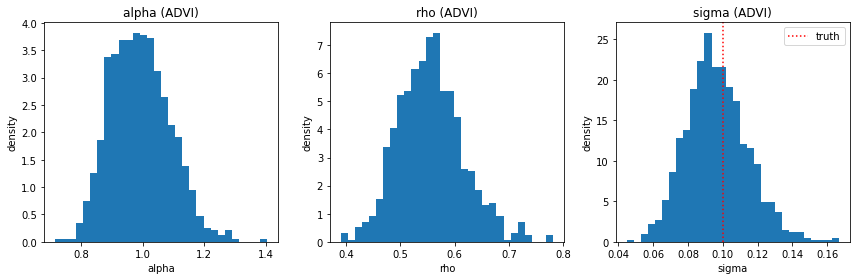

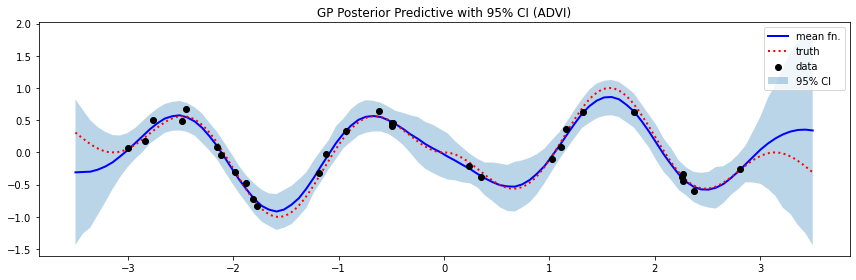

In [79]:
# Plot posterior for ADVI
gp_plot_util.make_plots(advi_posterior_samples, suffix="ADVI",
                        x=X.flatten(), y=y, x_grid=x_grid, f=f, sigma_true=simdata['sigma'])